![title](images/zillow_logo.png)

# MSDS 604 Time-Series Final Project 
 Group 17: Kyle Brooks, Nicolas Decavel-Bueff, Hsuan Yu Lin
## Table of Contents:
1. [Project Description](#proj_desc)


2. [Exploratory Data Analysis](#eda)


3. [Time Series Plots](#ts_eda)


4. [Univariate Models](#uni_models)
   - [ARIMA/SARIMA](#sarima)
   - [ETS](#ets)


5. [Univariate Results](#uni_results)


6. [Multivariate Models](#multi_models)
   - [SARIMAX](#sarimax)


7. [Final Model Selection and Evaluation](#final_model)

_________

###  Project Description <a id='proj_desc'></a>
##### Data Description:
- The Zillow dataset (modified) recorded Feb 2008- Dec 2015 monthly median sold price for housing in California, Feb 2008-Dec 2016 monthly median mortgage rate, and Feb 2008-Dec 2016 monthly unemployment rate.

##### Goal:
- Create the best model (either univariate or multivariate) in order to best predict the monthly median sold price between Jan, 2016 - Dec, 2016.
___________

### EDA <a id='eda'></a>
In order to create the best model, we most first understand our data. To start, let us load in the data, and look at each variable graphically.

In [58]:
# Imports for the following section
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [59]:
# Read in the data
df = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True, squeeze=True)\
        .rename({'MedianSoldPrice_AllHomes.California':'MedianSoldPrice'}, axis=1)
df

,MedianSoldPrice,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2016-08-31,NaN,3.46,4.8
2016-09-30,NaN,3.42,5.0
2016-10-31,NaN,3.36,5.0


Looking at the above dataset, we can see that some of the bottom values of MedianSoldPrice are NaN. This is because these are the dates that we want to predict on with our final model. For now, we can set these dates aside

In [60]:
leave_alone = df[df.index > '2016-01-01']
df = df[df.index < '2016-01-01']
leave_alone.shape, df.shape

((12, 3), (95, 3))

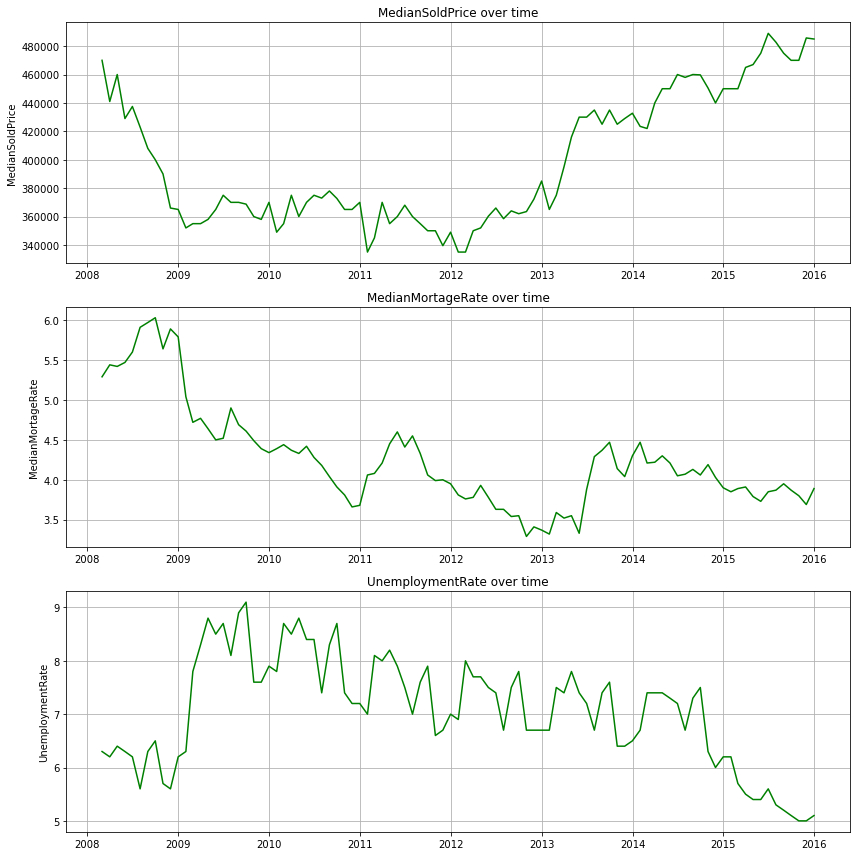

In [61]:
cols = df.columns

fig, axes = plt.subplots(figsize=(12,12), nrows=3)

for col, ax in zip(cols, axes):
    ax.plot(df[col], color='g')

    ax.set_title(f'{col} over time')
    ax.set_ylabel(col)
    ax.grid()

plt.tight_layout()
plt.show()

Looking at the above graphs, we notice a couple of things:
   1. The scale of each variables is pretty drastic. Therefore, we can normalize them in order to better understand their relationships on a single graph.
   2. Upon first glance, it looks like MedianSoldPrice will need to be differenced at least once since it seems like there is some sort of trend.
   3. In addition, we can visually see the Housing Market Crash at between 2008-2009 where the MedianSoldPrice drops dramatically.
   
### Upon further examination, since the goal is to predict 2016-2017, including the market crash and recovery from 2008-2009 may make my model even worse. Therefore, I am going to remove those years when choosing my best model.
   ______

In [62]:
df = df[df.index >= '2010-01-01']
df.shape

(72, 3)

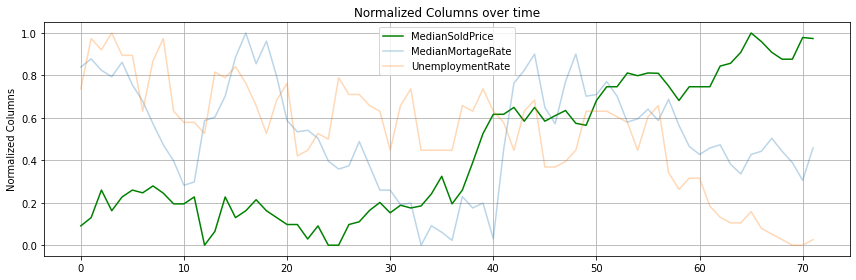

In [63]:
cols = df.columns

fig, ax = plt.subplots(figsize=(12,4))

for col in cols:
    # Normalize:
    sc = MinMaxScaler(feature_range=(0,1))
    normalized = sc.fit_transform(df[col].values.reshape(-1,1))
    if col == 'MedianSoldPrice':
        ax.plot(normalized, label=col, alpha=1, c='g')
    else:
        ax.plot(normalized, label=col, alpha=0.3)
    

    ax.set_title(f'Normalized Columns over time')
    ax.set_ylabel('Normalized Columns')
    ax.grid()

plt.legend()
plt.tight_layout()
plt.show()

Looking at the above graph, we can notice a couple of things:
   1. There might be an inverse relationship with **UnemploymentRate and MedianSoldPrice**
   
       - This makes sense because the MedianSoldPrice is dependent on the demand for houses, which can be severly impacted if there is a high unemployment rate because people who are unemployed are more likely to not buy a house. This can potentially be an **endogenous** variable because UnemploymentRate is not decided by MedianSoldPrice. 
       
       
   2. There can also be a relationship between **MedianMortageRate and MedianSoldPrice**
      - This relationship is not as apparent as the previous one. However, it looks like there is a delayed relationship between the two. This can potentially be an **exogenous** variable because MedianMortageRate might be a factor of MedianSoldPrice
_________
### Time Series Plots <a id='ts_eda'></a>
When fitting a Time Series model, in particular, ARIMA, we must first make sure that our data is stationary. In order to do so, we can perform the **adfuller test** and difference the data until we can reject the null hypothesis that the data is not stationary.

In [64]:
# Imports needed:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

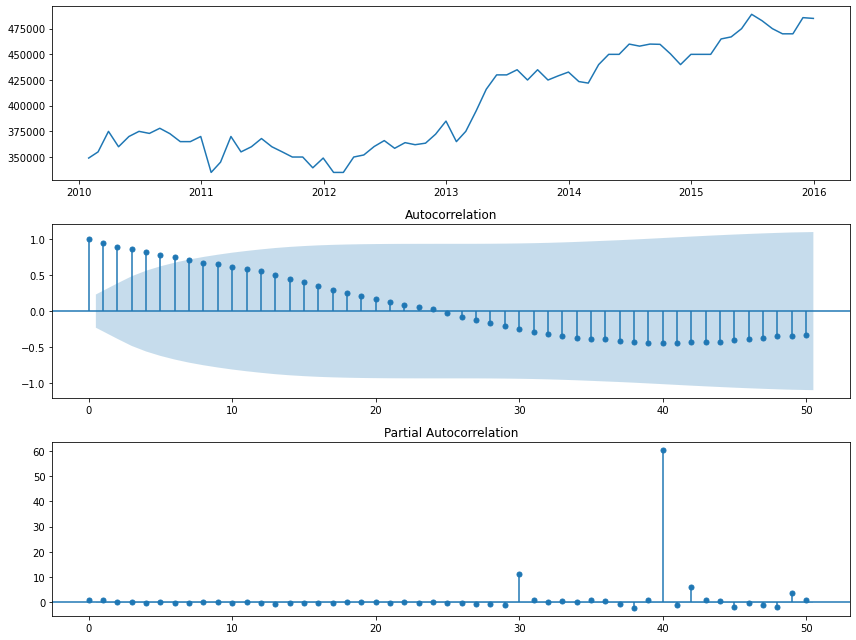

Test Statistic   -0.677591
p-value           0.852469
dtype: float64

In [65]:
fig, axes = plt.subplots(figsize=(12,9), nrows=3)
axes[0].plot(df['MedianSoldPrice'])
plot_acf(df['MedianSoldPrice'], lags=50, ax=axes[1])
plot_pacf(df['MedianSoldPrice'], lags=50, ax=axes[2])
plt.tight_layout()
plt.show()
pd.Series(adfuller(df['MedianSoldPrice'], autolag="AIC")[:2],
        index=['Test Statistic', 'p-value'])


#### Result: As we can see by the ACF, it doesn't seem like our data is currently stationary. In addition, the adfuller test confirms with a high p-value that our data is **not** stationary.

Next, let us try differencing our data once and then view the given plots again to see if that will be enough to get MedianSoldPrice to be stationary.

In [66]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

Differencing once


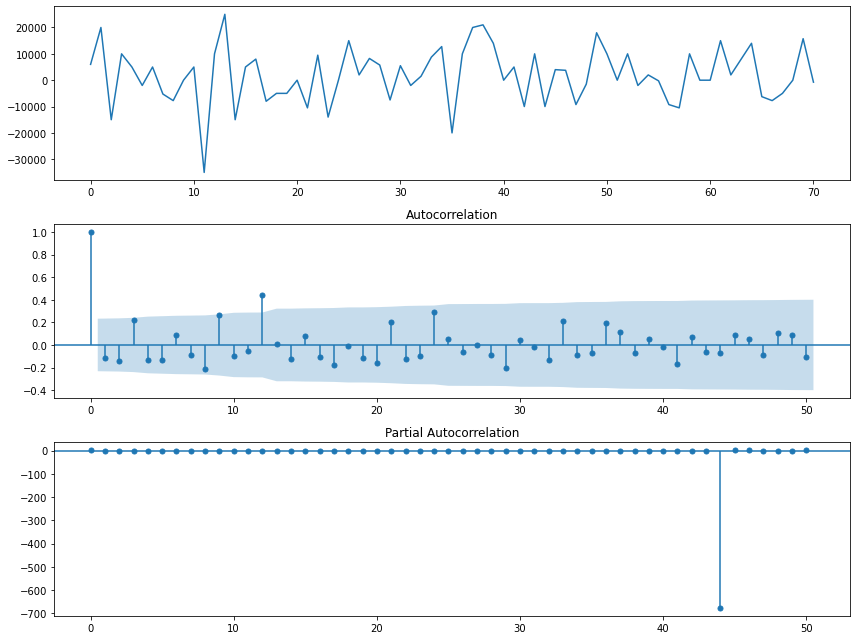

Test Statistic   -1.636414
p-value           0.464135
dtype: float64
Differencing twice


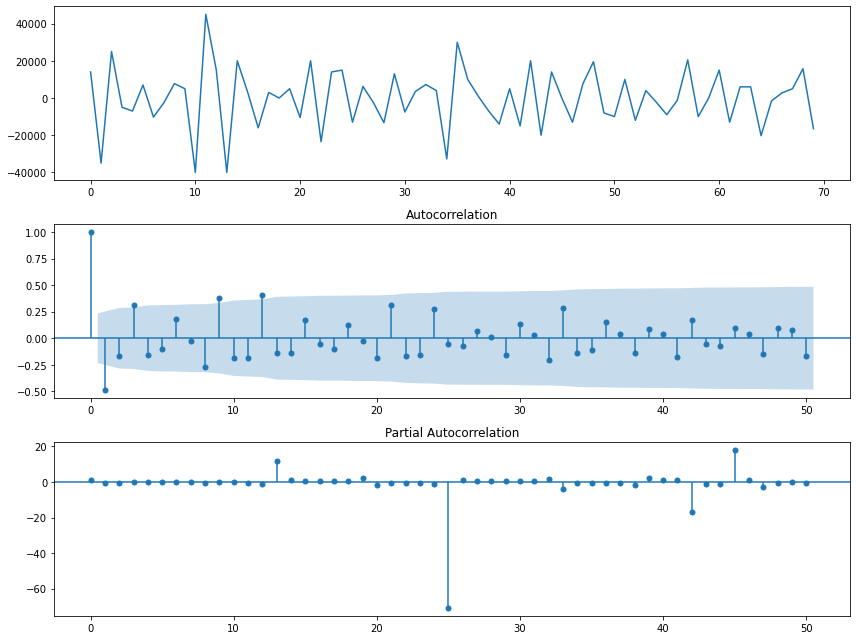

Test Statistic   -7.415506e+00
p-value           6.952725e-11
dtype: float64

In [67]:
differenced_df = diff(df['MedianSoldPrice'])

print('Differencing once')
fig, axes = plt.subplots(figsize=(12,9), nrows=3)
axes[0].plot(differenced_df)
plot_acf(differenced_df, lags=50, ax=axes[1])
plot_pacf(differenced_df, lags=50, ax=axes[2])
plt.tight_layout()
plt.show()
print(pd.Series(adfuller(differenced_df, autolag="AIC")[:2],
        index=['Test Statistic', 'p-value']))

print('Differencing twice')
differenced_df_2 = diff(differenced_df)
fig, axes = plt.subplots(figsize=(12,9), nrows=3)
axes[0].plot(differenced_df_2)
plot_acf(differenced_df_2, lags=50, ax=axes[1])
plot_pacf(differenced_df_2, lags=50, ax=axes[2])
plt.tight_layout()
plt.show()
pd.Series(adfuller(differenced_df_2, autolag="AIC")[:2],
        index=['Test Statistic', 'p-value'])

#### Result: As we can see, differencing the data twice makes the MedianSoldPrice stationary

Next, let us look at seasonal differencing to try and identify our seasonality

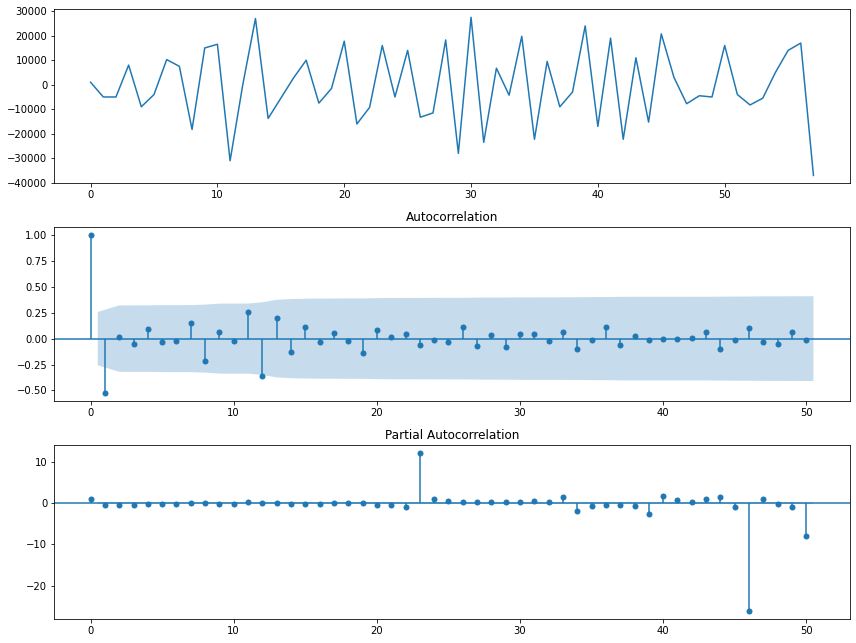

Test Statistic   -7.415506e+00
p-value           6.952725e-11
dtype: float64

In [68]:
d = diff(differenced_df_2, 12) #m=12 seasonal differencing
fig, axes = plt.subplots(figsize=(12,9), nrows=3)
axes[0].plot(d)
plot_acf(d, lags=50, ax=axes[1])
plot_pacf(d, lags=50, ax=axes[2])
plt.tight_layout()
plt.show()
pd.Series(adfuller(differenced_df_2, autolag="AIC")[:2],
        index=['Test Statistic', 'p-value'])

#### Result: We decided to use a seasonality of 12 since the data is monthly data and that seems to make the most sense in order to capture the seasonality in the model.
____________
## Univariate Models <a id='uni_models'></a>
To start modeling, we will focus on a more simple, univariate model with just MedianSoldPrice. Note that we will not be modeling a Prophet model because we are working with monthly data and Prophet performs better with daily/sub-daily data 
### ARIMA/SARIMA <a id='sarima'></a>
Steps:
1. Import all necessary libraries for this section
1. Define the functions we will need
1. Choose a candidate ARIMA model to serve as our baseline
1. Use BIC to choose our SARIMA model
1. Plot both candidate models to visually compare
1. Use cross validation to compare the RMSE of our two candidate models that we chose above


#### Note: Due to the fact that we don't have a validation set. I will use the year of 2015 as our validation to test the final univariate models to see which is better

In [69]:
train_df = df[df.index < '2015-01-01']
valid_df = df[df.index > '2015-01-01']

In [70]:
# 1. Imports
from math import sqrt

from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [71]:
# 2. Functions
def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1,):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    bic=res.bic
                                    if bic < best_score:
                                        print(f'Model: {order}-{seasonal_order} w/ Score: {bic:>10.2f}')
                                        best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                except:
                                    continue
    print(f"Best Model: {(best_order, best_seasonal_order)} w/ Score: {best_score:>10.2f}")

def evaluate_sarima(X, trend_order, seasonal_order, split=0.8, rmse=True):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test.iloc[t]) #store observation
        # calculate out of sample error
    if rmse:
        res = mean_squared_error(test, predictions, squared=False)
    else:
        res = mean_absolute_percentage_error(test, predictions)
    return res

In [72]:
# 3. Grid search for ARMA model (set P, Q, m and D to 0)
p_values = range(0, 5)
d_values = [2] 
q_values = range(0, 5)
P_values = range(0, 1)
m = 0
Q_values = range(0, 1)
bic_sarima(train_df['MedianSoldPrice'], p_values,d_values,q_values,P_values,Q_values,m, D=0)
# Candidate 1: Trend = (0, 2, 4)

Model: (0, 2, 0)-(0, 0, 0, 0) w/ Score:    1273.23
Model: (0, 2, 1)-(0, 0, 0, 0) w/ Score:    1228.41
Model: (0, 2, 2)-(0, 0, 0, 0) w/ Score:    1201.42
Model: (0, 2, 3)-(0, 0, 0, 0) w/ Score:    1181.36
Model: (0, 2, 4)-(0, 0, 0, 0) w/ Score:    1160.26
Best Model: ((0, 2, 4), (0, 0, 0, 0)) w/ Score:    1160.26


#### Candidate 1 (ARIMA): Trend Order of (0,2,4)

In [73]:
# 4. Grid search for SARIMA model
p_values = [0] #range(0, 5)
d_values = [2] 
q_values = [4] #range(0, 5)
P_values = range(0, 5)
m = 12
Q_values = range(0, 5)
bic_sarima(train_df['MedianSoldPrice'], p_values,d_values,q_values,P_values,Q_values,m, D=1)
# Candidate 2: (0, 2, 4), (0, 1, 3, 12)

Model: (0, 2, 4)-(0, 1, 0, 12) w/ Score:     885.94
Model: (0, 2, 4)-(0, 1, 2, 12) w/ Score:     367.21
Model: (0, 2, 4)-(0, 1, 3, 12) w/ Score:     114.32
Best Model: ((0, 2, 4), (0, 1, 3, 12)) w/ Score:     114.32


#### Candidate 2 (SARIMA): Trend Order: (0,2,4)   Seasonal Order: (0,1,3,12)   Seasonality = 12

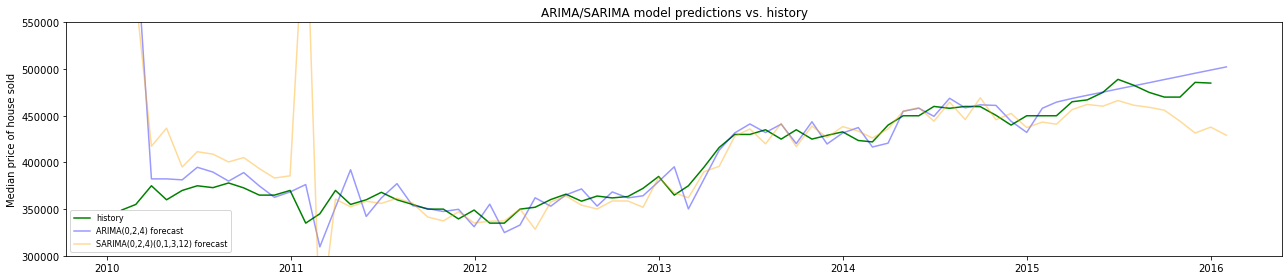

In [75]:
# 5. Plot both Candidates to visually compare the two

# ARIMA Candidate
mod1 = sm.tsa.statespace.SARIMAX(train_df['MedianSoldPrice'],order=(0,2,4),seasonal_order=(0,0,0,0))
res1 = mod1.fit()
pred1 = res1.predict(start=1, end=len(train_df) + len(valid_df))

# SARIMA Candidate 1
mod2 = sm.tsa.statespace.SARIMAX(train_df['MedianSoldPrice'],order=(0,2,4),seasonal_order=(0,1,3,12))
res2 = mod2.fit()
pred2 = res2.predict(start=1, end=len(train_df) + len(valid_df))

# Plot
plt.figure(figsize=(18,4))
plt.plot(df['MedianSoldPrice'], label='history', color='g')
plt.plot(pred1, label='ARIMA(0,2,4) forecast', color='b', alpha=0.4)
plt.plot(pred2, label='SARIMA(0,2,4)(0,1,3,12) forecast', color='orange', alpha=0.4)
plt.legend(fontsize=8)
plt.ylim([300000, 550000])
plt.title('ARIMA/SARIMA model predictions vs. history')
plt.ylabel('Median price of house sold')
plt.tight_layout()
plt.show()

#### Results: As we can see in the above graph, It seems like both SARIMA and ARIMA have huge spikes at the beginning that are most likely accounting for super high RMSE scores. That being said, the ARIMA model seems to be better in predicting the new year between 2015 and 2016.

In [36]:
# 6. Use cross-validation to compare both models. We chose a 67% split because we wanted to see 
# how our model does over a longer period of time.
rmse_candidate_1 = evaluate_sarima(train_df['MedianSoldPrice'], 
                                   trend_order=(0,2,4), 
                                   seasonal_order=(0,0,0,0), 
                                   split=0.8)

rmse_candidate_2 = evaluate_sarima(train_df['MedianSoldPrice'], 
                                   trend_order=(0,2,4), 
                                   seasonal_order=(0,1,3,12), 
                                   split=0.8)

mape_candidate_1 = evaluate_sarima(train_df['MedianSoldPrice'], 
                                   trend_order=(0,2,4), 
                                   seasonal_order=(0,0,0,0), 
                                   split=0.8,
                                   rmse=False)

mape_candidate_2 = evaluate_sarima(train_df['MedianSoldPrice'], 
                                   trend_order=(0,2,4), 
                                   seasonal_order=(0,1,3,12), 
                                   split=0.8,
                                   rmse=False)

In [37]:
print(f"{'ARIMA Candidate':<20}RMSE: {rmse_candidate_1:.2f} MAPE: {mape_candidate_1:.5f}")
print(f"{'SARIMA Candidate':<20}RMSE: {rmse_candidate_2:.2f} MAPE: {mape_candidate_2:.5f}")

ARIMA Candidate     RMSE: 10758.00 MAPE: 0.02060
SARIMA Candidate    RMSE: 16030.46 MAPE: 0.02774


#### Results: We can see that our ARIMA model does better.

### SARIMA Univariate Results:
1. Candidate 1: (ARIMA) had a smaller RMSE, however, it could be due to SARIMA's multiple large outliers. Regardless, it seems to capture the new year (2015-2016) the best.
    - Trend Order: (0,2,4)
2. Candidate 2: (SARIMA) had a worse RMSE, and the graph seems to not capture the relationship as well.
    - Trend Order: (0,2,4)
    - Seasonal Order: (0,1,3,12)

__________
### ETS <a id='ets'></a>
Now we will try to model MedianSalePrice with exponential smoothing.
Steps:
1. Imports
2. Functions
3. Grid Search for best ETS model
4. Graph the ETS model

In [76]:
# 1. Imports
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [87]:
# 2. Functions

def evaluate_ets(X, Trend, Seasonal, m, rmse=True):
    train_size = int(len(X) * 0.67)
    train, test = X[0:train_size], X[train_size:]
    
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    if rmse:
        try:
            res = mean_squared_error(test, predictions, squared=False)
        except ValueError:
            res = float("inf")
    else:
        # Default to MAPE
        res = mean_absolute_percentage_error(test, predictions)
    return res


In [88]:
# 3. Grid search for best ETS model:
trends = ['add', 'multiplicative', None]
seasonalities = ['add', 'multiplicative']
m = 12

for trend in trends:
    for seasonality in seasonalities:
        score = evaluate_ets(train_df['MedianSoldPrice'], trend, seasonality, m)
        print(f'Model ({trend}, {seasonality}) - {score:.2f}')


Model (add, add) - 9855.49
Model (add, multiplicative) - 97782.63
Model (multiplicative, add) - inf
Model (multiplicative, multiplicative) - inf
Model (None, add) - 8641.55
Model (None, multiplicative) - 8916.00


#### Results: Here we will choose to graph the best model and include our multiplicative/additive model even though there was an issue with calculating its RMSE
1. Candidate 3: (mul, add)
2. Candidate 4: (None, add)

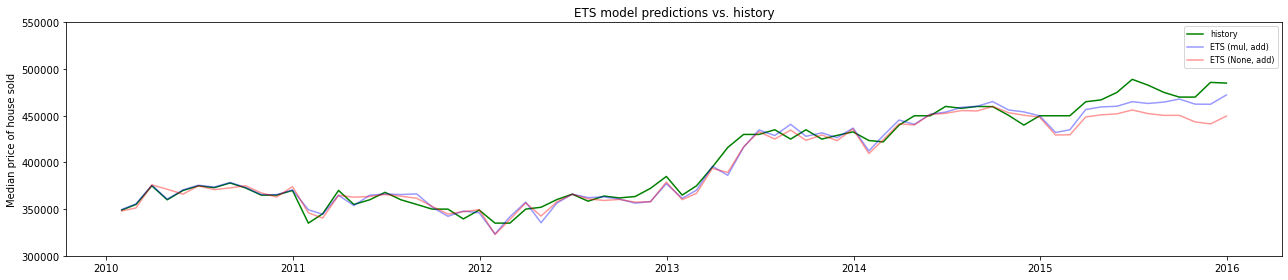

In [90]:
# 4. Graph ETS candidate model:

# ETS Candidate 1
mod1 = ExponentialSmoothing(train_df['MedianSoldPrice'], trend='mul', seasonal='add', seasonal_periods=12)
res1 = mod1.fit()
values = res1.fittedvalues
pred1 = values.append(res1.forecast(12))

# ETS Candidate 2
mod2 = ExponentialSmoothing(train_df['MedianSoldPrice'], trend=None, seasonal='add', seasonal_periods=12)
res2 = mod2.fit()
values = res2.fittedvalues
pred2 = values.append(res2.forecast(12))


# Plot
plt.figure(figsize=(18,4))
plt.plot(df['MedianSoldPrice'], label='history', color='g')
plt.plot(pred1, label='ETS (mul, add)', color='b', alpha=0.4)
plt.plot(pred2, label='ETS (None, add)', color='r', alpha=0.4)
plt.legend(fontsize=8)
plt.ylim([300000, 550000])
plt.title('ETS model predictions vs. history')
plt.ylabel('Median price of house sold')
plt.tight_layout()
plt.show()

#### Results: Graphically, we can see that our exponential smoothing with multiplicative trend and an additive seasonality does the best.

_________
## Univariate Model Results <a id='uni_results'></a>
In this section, we focused on creating a simpler model with just a single variable (MedianSoldPrice) and seeing how different models perform. Here is a brief overview of the different models we chose and their respective RMSE scores (when evaluated on an 80% cross-val split)
1. ARIMA:
    - Trend Order: (0,2,4) -> RMSE: 10758.00
2. SARIMA: 
    - Trend (0,2,4) and Seasonal (0,1,3,12) -> RMSE: 16030.46
3. ETS:
    - Trend(multiplicative) and Seasonal(additive) w/ seasonal_periods=12 -> RMSE: Not applicable, but visually pretty good!
    - Trend(None) and Seasonal(additive) w/ seasonal_periods=12 -> RMSE: 8641.55


    
Now, since this data is a little bit more complicated and we have access to other variables, let us look at running some **multi-variate** models
_________
## Multivariate Models <a id='multi_models'></a>
In this section, we will be focusing on 2 different models: SARIMAX and VAR. 
Note that SARIMAX assumes that the other columns are exogenous features, while VAR assumes them to be endogenous:
_____
### SARIMAX <a id='sarimax'></a>
With a SARIMAX, it is recommended to normalize the features for a better prediction.
Steps:
1. Drop NaN
2. Normalize
3. Run auto_arima w/ seasonaliy (with UnemploymentRate = exogenous)
4. Run auto_arima w/ seasonaliy (with MedianMortageRate = exogenous)
5. Graph the two models
6. Calculate RMSE on our validation set

In [91]:
# Imports
from pmdarima.arima import auto_arima

In [92]:
# 1. Drop NaN
exog_df = df
train_exog, valid_exog = exog_df[exog_df.index < '2015-01-01'], exog_df[exog_df.index > '2015-01-01']

In [93]:
# 2. Normalize
sc = MinMaxScaler(feature_range=(0,1))

train_sc = sc.fit_transform(train_exog)
valid_sc = sc.fit_transform(valid_exog)

In [96]:
# 3. Auto Arima w seasonality (UnemploymentRate = exogenours)
i_o_i = list(train_exog.columns).index('UnemploymentRate')
model1=auto_arima(train_sc[:,0], # MedianSoldPrice is endogenous
                 exogenous= train_sc[:,i_o_i].reshape(-1,1), # UnemploymentRate = exogenours
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=3,
                 m=12, D=1, max_P=4, max_Q=4,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-107.954, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-103.714, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-109.514, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-110.029, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-104.330, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-108.037, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-108.037, Time=0.43 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-109.119, Time=0.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-106.038, Time=0.79 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-109.864, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-108.380, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-109.146, Time=0.24 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-110.380, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-104.781, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1

#### Results: Our best Model here is SARIMAX(1,1,0)(0,1,1,12)

In [97]:
# 3. Auto Arima w seasonality using MedianMortageRate and UnemploymentRate as exogenous
from pmdarima.arima import auto_arima

model2=auto_arima(train_sc[:,0], # MedianSoldPrice is endogenous
                 exogenous= train_sc[:,1:], # rest is exogenous
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=3,
                 m=12, D=1, max_P=4, max_Q=4,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-106.419, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-102.071, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-108.276, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-108.399, Time=0.50 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-102.590, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-106.402, Time=0.74 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-106.402, Time=0.85 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-107.708, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-104.401, Time=0.91 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-108.248, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-106.951, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-108.793, Time=0.38 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=-104.615, Time=0.20 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=-106.843, Time=0.56 sec
 ARIMA(0,1,2)(0,1,2

#### Result: Our best Model here is SARIMA(1,1,2)(0,1,1,12)

In [98]:
# 5. Graph the two model's predictions
# SARIMAX (1,1,0) (0,1,1,12)
y_pred = model1.predict(n_periods=len(valid_sc),X=valid_sc[:,2].reshape(-1,1)).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv_1 = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (MedianSoldPrice)

# SARIMAX (1,1,2)(0,1,1,12)
y_pred = model2.predict(n_periods=len(valid_sc),X=valid_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv_2 = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (MedianSoldPrice)


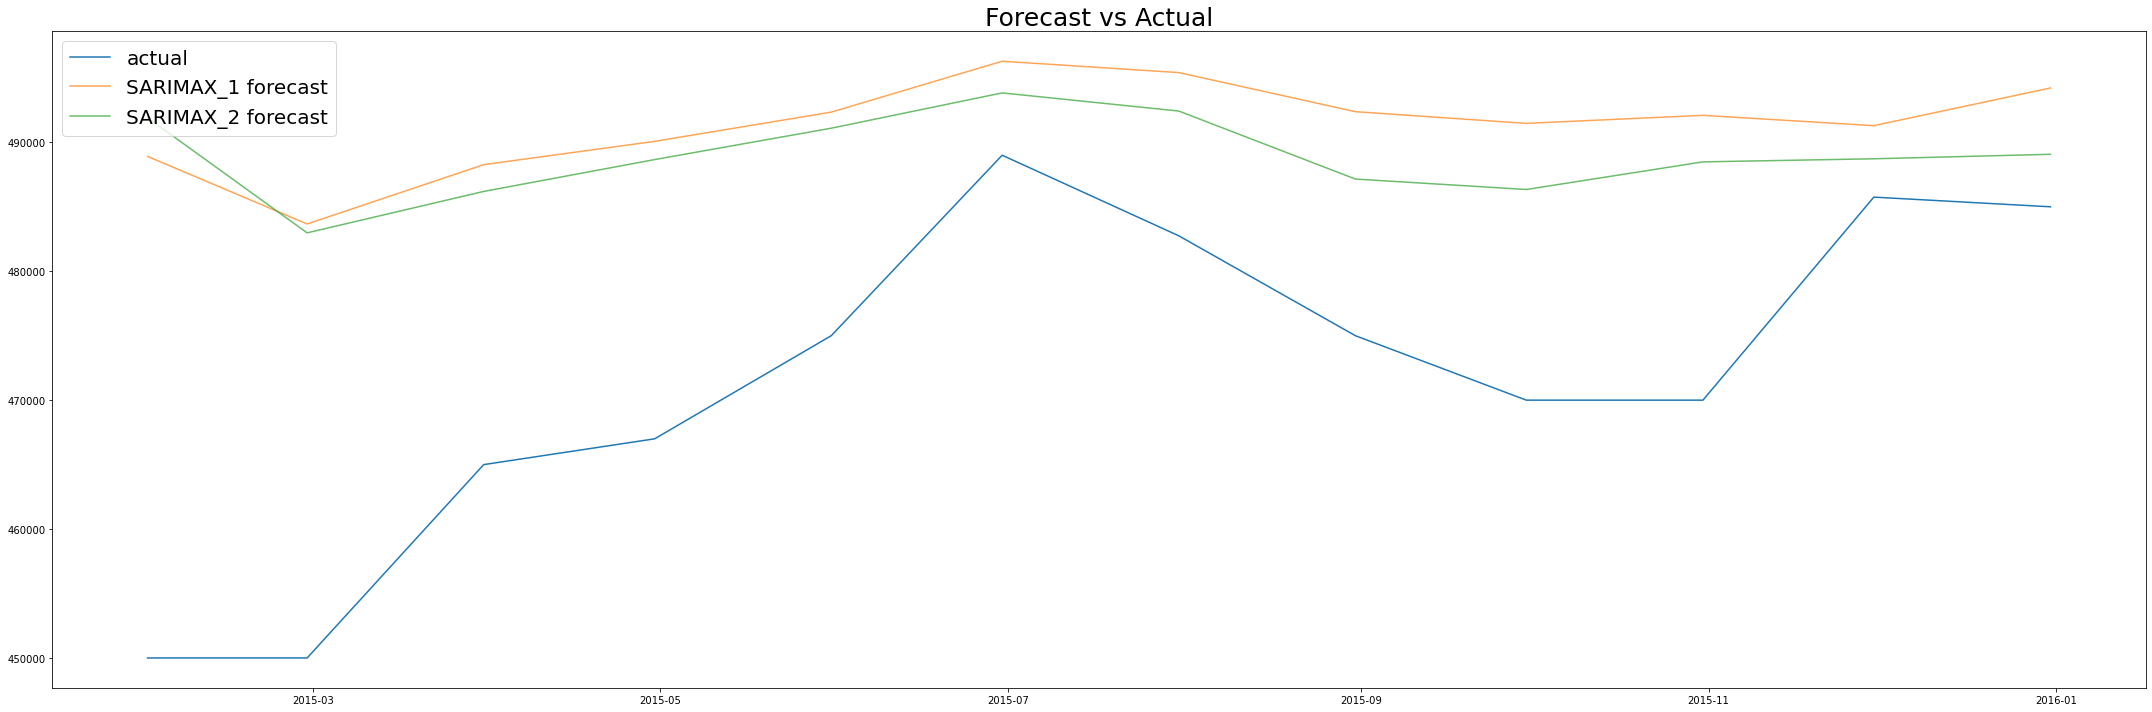

In [114]:
y_pred_series_1 = pd.Series(y_pred_inv_1,index=valid_df.index)
y_pred_series_2 = pd.Series(y_pred_inv_2,index=valid_df.index)

plt.figure(figsize=(30, 10))

plt.plot(valid_df['MedianSoldPrice'], label='actual')
plt.plot(y_pred_series_1, label='SARIMAX_1 forecast', alpha=0.7)
plt.plot(y_pred_series_2, label='SARIMAX_2 forecast', alpha=0.7)

plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25)
plt.tight_layout()
plt.show()

In [115]:
# 6. Get RMSE of both:
rmse_1 = mean_squared_error(valid_df['MedianSoldPrice'], y_pred_inv_1, squared=False)
rmse_2 = mean_squared_error(valid_df['MedianSoldPrice'], y_pred_inv_2, squared=False)
print(f'Model 1 w/ UnemploymentRate as exogenous: RMSE = {rmse_1:.2f}')
print(f'Model 2 w/ UnemploymentRate and MedianMorgageRate as exogenous: RMSE = {rmse_2:.2f}')

Model 1 w/ UnemploymentRate as exogenous: RMSE = 21607.14
Model 2 w/ UnemploymentRate and MedianMorgageRate as exogenous: RMSE = 20248.59


#### Results:
1. Looking at both models, we can see that the one that took more variables into account had a lower RMSE on our validation set.
__________

# Final Model Selection: SARIMAX <a id='final_model'></a>
Steps:
1. Get test data
2. Combine test and our initial dataframe
3. Remove the housing-bubble from our training as that was an anomaly. We decided to start our data in 2010
3. Run selected model and calculate our final RMSE

In [116]:
test_df = pd.read_csv('test.csv', index_col='Month', parse_dates=True)\
.rename({'Median House Price':'MedianSoldPrice'}, axis=1)
train_df = pd.concat([df, leave_alone])
test_df.head(3)

,MedianSoldPrice
Month,
2016-01-31,476250
2016-02-29,466000
2016-03-31,485000


In [117]:
total_df = pd.merge(train_df, test_df, left_on=train_df.index, right_on=test_df.index, how='left')

In [118]:
def combine(x):
    return np.nanmax([x['MedianSoldPrice_x'], x['MedianSoldPrice_y']])

In [119]:
total_df['MedianSoldPrice'] = total_df.apply(combine, axis=1)
total_df = total_df.rename({'key_0':'Date'}, axis=1).set_index('Date', drop=True)\
       .drop(['MedianSoldPrice_x', 'MedianSoldPrice_y'], axis=1)

In [120]:
threshold = '2016-01-01'
train_df = total_df[total_df.index < threshold]
test_df = total_df[total_df.index > threshold]
column_order = ['MedianSoldPrice', 'MedianMortageRate', 'UnemploymentRate']
train_df = train_df[column_order]
test_df = test_df[column_order]
train_df = train_df[train_df.index > '2010-01-01']
train_df_normalized = sc.fit_transform(train_df)
test_df_normalized = sc.transform(test_df)

In [121]:
# 3. Run selected Model and calculate final RMSE
# SARIMAX
model = auto_arima(train_df_normalized[:,0], # gdp as endogenous
                 exogenous= train_df_normalized[:,1:], # rest as exogenous
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 m=12, D=1, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-38.884, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-159.990, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-14.824, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-153.068, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-160.672, Time=1.32 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=-157.774, Time=2.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-157.024, Time=1.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-160.804, Time=0.62 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-161.283

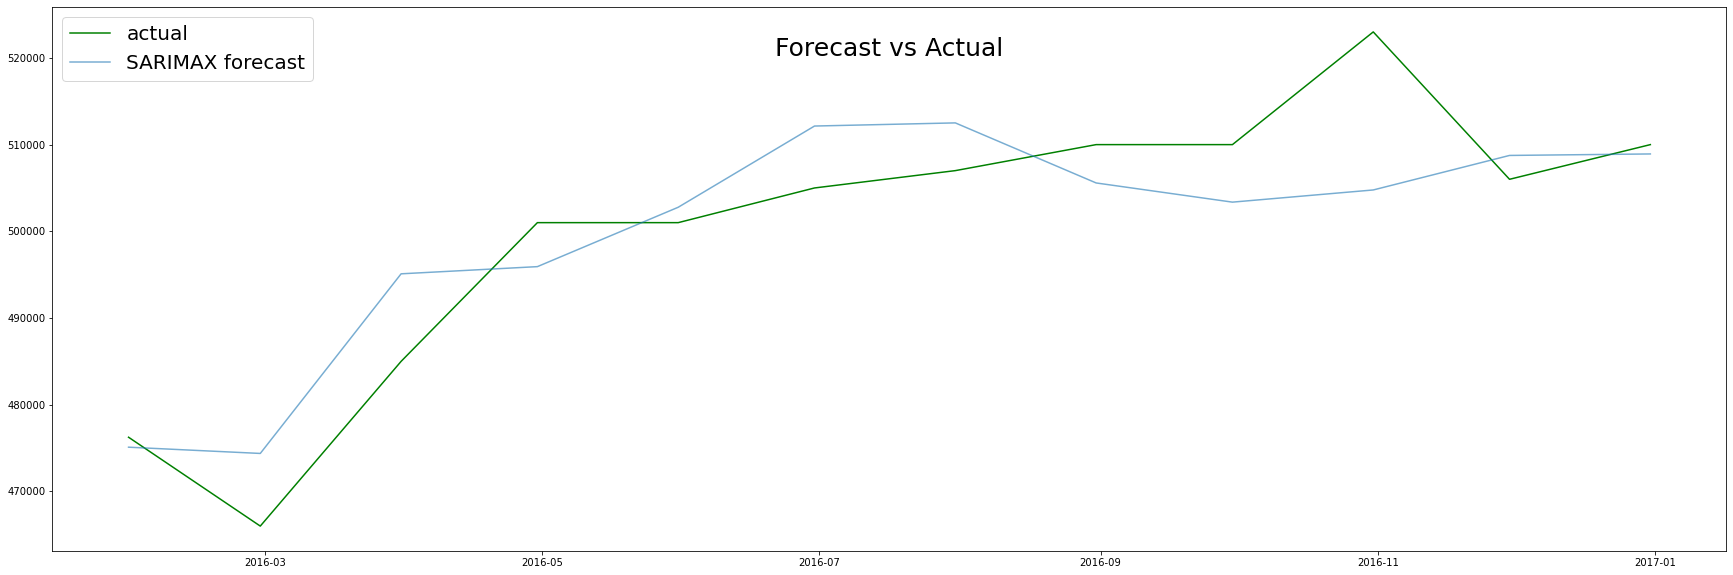

In [122]:
y_pred = model.predict(n_periods=len(test_df_normalized),
                       X=test_df_normalized[:,1:3]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (MedianSoldPrice)


y_pred_series = pd.Series(y_pred_inv,index=test_df.index)
plt.figure(figsize=(30, 10))

plt.plot(test_df['MedianSoldPrice'], label='actual', color='g')
plt.plot(y_pred_series, label='SARIMAX forecast', alpha=0.6)

plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [123]:
# Calculate RMSE:
rmse = mean_squared_error(test_df['MedianSoldPrice'], y_pred_inv, squared=False)
rmse

7573.881895486904

_______
# Conclusion:
1. Final Model: SARIMAX model with both UnemploymentRate and MedianMortageRate as exogenous variables.
2. Final Data: In order to have a better model, we decided to disregard both 2008 and 2009 from the training data because those both represent the housing-market crash and the start of the recovery. 
3. Final Result: Our prediction on 2016 gave us an RMSE of **7573.881895486904**